# Introduction



This analysis will be carried out based on the US politicians' tweets dataset, consisting of the text of a large sample of tweets from 2008 to 2017. The goal behind it will be to better understand how politicians communicate with the public at large, something that could be of interest to its citizenry.
The main hypothesis relates to the way they express on social networks, by means of a sensitivity analysis, in order to find out if they speak more positively when their party is in power and a more negative one when it's the national opposition.


# Loading the data and Exploratory Data Analysis

Naturally, the first step is to read the JSON data:

In [34]:
import json
import pandas as pd
data= open("C:/Rprojects/SQL tweets/tweets.json")
tweets = []
for line in data:
    tweets.append(json.loads(line))

In [35]:
import random
import datetime

df=pd.DataFrame(tweets)

In [36]:
pd.set_option('display.max_colwidth', None)
df.head()

,contributors,coordinates,created_at,display_text_range,entities,favorite_count,favorited,geo,id,id_str,...,text,truncated,user_id,possibly_sensitive,extended_entities,quoted_status_id,quoted_status_id_str,withheld_copyright,withheld_in_countries,withheld_scope
0,None,None,1217870931,"[0, 74]","{'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []}",0,False,None,877418565,877418565,...,On a conference call about a weekend trip to Iraq to visit Arkansas troops,False,5558312,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,None,None,1218049485,"[0, 25]","{'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []}",0,False,None,879618172,879618172,...,Being interviewed by KTHV,False,5558312,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,None,None,1218054936,"[0, 65]","{'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []}",0,False,None,879695803,879695803,...,Being interviewed by KARN on his Arkansas World Trade Center trip,False,5558312,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,None,None,1218117172,"[0, 37]","{'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []}",0,False,None,880393665,880393665,...,"On KWHN in Fort Smith, that's 1320 AM",False,5558312,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,None,None,1218121925,"[0, 90]","{'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []}",0,False,None,880474266,880474266,...,Attending a Military of the Purple Heart Ceremony at the VA Medical Center in Fayetteville,False,5558312,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
import duckdb
tweetcount= duckdb.query("""SELECT count(*) as cnt, user_id, screen_name, 
CASE WHEN screen_name LIKE 'Rep%' THEN 1 ELSE 0 END AS Rep 
FROM df group by user_id, screen_name order by cnt desc""").df()

In [38]:
print('percentage of accounts starting with "@Rep": ' + str(sum(tweetcount['Rep'])/len(tweetcount.index)))
print('number of tweets by name of account:')
duckdb.query("""SELECT count(*) as nTweets, 
CASE WHEN screen_name LIKE 'Rep%' THEN 1 ELSE 0 END AS Rep 
FROM df group by Rep""").df()

print('The "Rep accounts" are have significantly fewer tweets per account')

percentage of accounts starting with "@Rep": 0.4954128440366973
number of tweets by name of account:
The "Rep accounts" are have significantly fewer tweets per account


I'll make map of tweets by location from the small (in %) set of tweets that have geolocalization
a few come from Washington DC, while the vast majority have been uploaded from the Eastern half of the US


In [39]:
import folium
dfgeo = df[df.geo.notnull()]
dfgeo2 =list(dfgeo.geo)
m = folium.Map(location=[40, -100], zoom_start=4)
for item in dfgeo2[:500]:
    folium.Marker(
    location=item['coordinates'],
    popup="point",
    ).add_to(m)
m

The vast majority of tweets come from the eastern half of the US, although there is an odd gap in the Michigan-Alabama line

DC seems to have a significant number of tweets, as could be expected given the abundance of Representatives and Senators in the data

Next, I will derive some information about the temporal distribution of tweets. We don't have to deal with missing values here

In [40]:
df['tweetsday'] = pd.to_datetime(df['created_at'], errors='coerce', unit='s')

In [41]:
days= df[['tweetsday']].groupby(by=df['tweetsday'].dt.date).count()

In [42]:
rows=days.iloc[[0,-1]].index.tolist()
idx = pd.date_range(rows[0].isoformat(), rows[1].isoformat())
days2 = days.reindex(idx, fill_value=0)
dates=days2.index.tolist()
days2['day']=dates

The days with the most tweets:

In [43]:
duckdb.query("""Select * from 'days2' order by tweetsday desc""").df().head()

,tweetsday,day
0,4056,2017-03-01
1,3443,2017-05-04
2,3303,2016-01-13
3,3268,2016-06-22
4,3063,2016-06-23


They all correspond to the last two years of the data, which makes sense given Twitter kept becoming more and more popular

Now we'll find out what the largest spikes in the number of tweets were (compared to the number of tweets in the previous week)

In [44]:
import numpy as np
days3=days2[6:]
days3=days3.assign(weekavg=pd.Series(days2['tweetsday']).rolling(window=7).mean().iloc[7-1:].values)
days3['avgprevweek'] = days3.weekavg.shift(1)
days3['ratio'] = days3.tweetsday/days3.weekavg.shift(1)
days3 = days3[days3.ratio.notnull()]

In [45]:
duckdb.query("""select * from 'days3' where avgprevweek>3 order by ratio desc""").df().head(20)

,tweetsday,day,weekavg,avgprevweek,ratio
0,108,2011-01-05,31.142857,16.857143,6.406780
1,43,2009-02-25,12.142857,7.428571,5.788462
2,878,2015-01-06,264.714286,157.714286,5.567029
3,258,2013-01-02,84.000000,50.428571,5.116147
4,2392,2015-01-21,727.857143,506.285714,4.724605
5,30,2011-01-03,11.285714,7.000000,4.285714
6,1977,2014-01-29,651.714286,462.857143,4.271296
7,1580,2017-01-03,555.428571,375.428571,4.208524
8,47,2011-01-04,16.857143,11.285714,4.164557
9,3303,2016-01-13,1197.857143,887.857143,3.720193


(the days with very few tweets were filtered out as they were of little interest)

Now we'll plot the data and check if those dates are visible in the graph

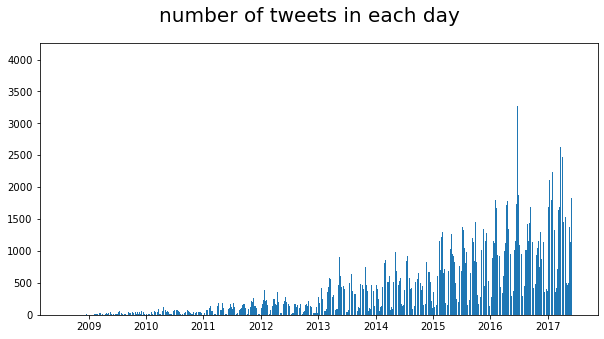

In [46]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
fig = plt.figure()
plt.bar(days2['day'], days2['tweetsday'])
fig.suptitle('number of tweets in each day', fontsize=20)
plt.show()

There are huge movements all the time, however, the variation in the first years is hard to see because of the growth in the number of tweets.

To have an idea of what it is that the tweets have been discussing, I'll draw a series of wordclouds for each year in the data

In [47]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
stop_words |= set(["&amp", "=", "great", "thanks", "rt", "w/", "", "new", "thank", "&amp;", "-", "today", "day", "here:"]) #set union

from collections import Counter
no_sw = df['text'].apply(lambda word: [word.lower() for word in word.split(' ') if word.lower() not in stop_words])

corpus=[]
for ea in no_sw:
    corpus += ea
wordDict = Counter(corpus)
[(k, v) for k, v in sorted(wordDict.items(), key= lambda item: item[1], reverse=True)][:20]

[('house', 42901),
 ('bill', 39072),
 ('us', 37006),
 ('support', 31332),
 ('time', 31233),
 ('help', 30946),
 ('work', 30078),
 ('must', 29821),
 ('need', 29391),
 ('health', 29329),
 ('proud', 28127),
 ('happy', 25835),
 ('join', 24980),
 ('see', 24583),
 ('congress', 23625),
 ('watch', 23569),
 ('american', 23269),
 ('state', 23214),
 ('good', 22974),
 ('act', 22835)]

In [48]:
t2008= duckdb.query("""select text from 'df' where year='2008'""").df()
t2009= duckdb.query("""select text from 'df' where year='2009'""").df()
t2010= duckdb.query("""select text from 'df' where year='2010'""").df()
t2011= duckdb.query("""select text from 'df' where year='2011'""").df()
t2012= duckdb.query("""select text from 'df' where year='2012'""").df()
t2013= duckdb.query("""select text from 'df' where year='2013'""").df()
t2014= duckdb.query("""select text from 'df' where year='2014'""").df()
t2015= duckdb.query("""select text from 'df' where year='2015'""").df()
t2016= duckdb.query("""select text from 'df' where year='2016'""").df()
t2017= duckdb.query("""select text from 'df' where year='2017'""").df()

RuntimeError: Binder Error: Referenced column "year" not found in FROM clause!
Candidate bindings: "df.text", "df.geo", "df.lang", "df.id", "df.place"

In [ ]:
from wordcloud import WordCloud

def wordcld(df_in):
    df = df_in.copy()
    df['text_no_sw']= df.text.apply(lambda word: [word.lower() for word in word.split(' ') if word.lower() not in stop_words])
    year_corpus = []
    for ea in df.text_no_sw:
        year_corpus += ea
    wordDict = Counter(year_corpus)
    wordcloud= WordCloud().generate_from_frequencies(wordDict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [ ]:
for year in range(2008, 2018):
    df_name='t'+str(year)
    print('congressmen tweets from', year)
    wordcld(eval(df_name))

As a first step in the main analysis, I create a user table that will store data on each politician who wrote a tweet, and will eventually include their real name and party. This table is ordered by the total number of times the person's tweets have been favorited, to see which the most popular accounts are.

In [ ]:
user=duckdb.query("""Select screen_name, sum(retweet_count) as total_retweeted, sum(favorite_count) as total_favorited, min(created_at) as date_first_tweet 
from df group by screen_name order by total_favorited desc""").df()
user.head()

# Hypothesis evaluation

Having finished with the descriptive section of the analysis, we will now move on to the examination of the hypothesis I started out with: Whether tweets written when the author's party was in power at a national level were more positive than when the roles were reversed.

To do this the first step is to obtain the party affiliation of each politician, which itself requires that we find the real names behind the Twitter usernames. To do this, I resorted to web scraping Bing searches of the usernames (that search engine is apparently the most permissive one for automatic scraping). 

The website govtrack.us keeps a record of all the Representatives and Senators in the US and looking at the search results from that website provides an easy way to relate the the account names to the people (being politicians, their usernames by and large reference their real names). Once I have the names of the politicians, I make another search to get their party affiliation, which I determine with another rough method: If searching their name + "party affiliation" returns the word "Democrat" more than "Republican" I assume that they are Democrats, and vice-versa.

In [ ]:
from bs4 import BeautifulSoup
import requests
import re
import time
from urllib.parse import urlencode, urlparse, parse_qs
from lxml import html
from requests import get

names=[]

term = 'python'
headers = {'User-Agent':'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36',
    "Accept-Encoding": "*",
    "Connection": "keep-alive"
          }
for name in user['screen_name']:
    url = ('https://www.bing.com/search?q=site%3Agovtrack.us+' + name).format(term)
    response = requests.get(url,headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    try:
        found = re.search('(Rep\.|Sen\.)([^\.\-’\(\[,]*)', soup.get_text()
        ).group(2)
    except:
        found = ''
    if "from the" in found:
        found=''
    names.append(found)

In [ ]:
for idx, name in enumerate(names):
    if '’' in name:
        names[idx]=name[:name.find('’')-1]
    if 'Statement' in name:
        names[idx]=name[:name.find('Statement')-2]
    if 'Reelected' in name:
        names[idx]=name[:name.find('Reelected')-2]

In [ ]:
user['name']=names

In [ ]:
party=[]
for name in user['name']:
    if name == "":
        party.append("")
        continue
    url = ('https://www.bing.com/search?q=' + name + ' party affiliation').format(term)
    response = requests.get(url,headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    dems=soup.get_text().count('Democrat') + soup.get_text().count('democrat')
    reps=soup.get_text().count('Republican') + soup.get_text().count('republican')
    if dems > reps:
        party.append("Democrat")
    elif reps > dems:
        party.append("Republican")
    else:
        party.append("")

In [ ]:
pd.set_option('display.max_rows', 2000)

For the most part this approach seems to have worked, but manual corrections were needed in a some cases, as well as to eliminate non-personal accounts such as @POTUS

In [ ]:
user['party']=party
user = user[user.screen_name != "POTUS"]
user = user[user.screen_name != "GovernorVA"]
user = user[user.screen_name != "GOPLeader"]
user = user[user.screen_name != "LouisianaGov"]
user = user[user.screen_name != "NC_Governor"]
user.loc[(user.screen_name=="GovSandoval"), 'name']="Brian Sandoval"
user.loc[(user.screen_name=="GovSandoval"), 'party']="Republican"
user.loc[(user.screen_name=="realDonaldTrump"), 'name']="Donald Trump"
user.loc[(user.screen_name=="realDonaldTrump"), 'party']="Republican"
user.loc[(user.screen_name=="jahimes"), 'name']='James "Jim" Himes'
user.loc[(user.screen_name=="jahimes"), 'party']="Democrat"
user.loc[(user.screen_name=="RepLawrence"), 'name']='Brenda Lawrence'
user.loc[(user.screen_name=="RepLawrence"), 'party']="Democrat"
user.loc[(user.screen_name=="ScottWalker"), 'name']='Scott Walker'
user.loc[(user.screen_name=="ScottWalker"), 'party']="Republican"
user.loc[(user.screen_name=="DrPhilRoe"), 'name']='Phil Roe'
user.loc[(user.screen_name=="DrPhilRoe"), 'party']="Republican"
user.loc[(user.screen_name=="jasoninthehouse"), 'name']='Jason Chaffetz'
user.loc[(user.screen_name=="jasoninthehouse"), 'party']="Republican"
user.loc[(user.screen_name=="NYGovCuomo"), 'name']='Andrew Cuomo'
user.loc[(user.screen_name=="NYGovCuomo"), 'party']="Democrat"
user.loc[(user.screen_name=="PattyMurray"), 'name']='Patty Murray'
user.loc[(user.screen_name=="PattyMurray"), 'party']="Democrat"
user.loc[(user.screen_name=="RepHastingsFL"), 'name']='Alcee Hastings'
user.loc[(user.screen_name=="RepHastingsFL"), 'party']="Democrat"
user.loc[(user.screen_name=="GovMaryFallin"), 'name']='Mary Fallin'
user.loc[(user.screen_name=="GovMaryFallin"), 'party']="Republican"
user.loc[(user.screen_name=="RosLehtinen"), 'name']='Ileana Ros-Lehtinen'
user.loc[(user.screen_name=="RosLehtinen"), 'party']="Republican"
user.loc[(user.screen_name=="WhipHoyer"), 'name']='Steny Hoyer'
user.loc[(user.screen_name=="WhipHoyer"), 'party']="Democrat"
user.loc[(user.screen_name=="GovChristie"), 'name']='Chris Christie'
user.loc[(user.screen_name=="GovChristie"), 'party']="Republican"
user.loc[(user.screen_name=="JerryBrownGov"), 'name']='Jerry Brown'
user.loc[(user.screen_name=="JerryBrownGov"), 'party']="Democrat"
user.loc[(user.screen_name=="OregonGovBrown"), 'name']='Kate Brown'
user.loc[(user.screen_name=="OregonGovBrown"), 'party']="Democrat"
user.loc[(user.screen_name=="PhilBryantMS"), 'name']='Phil Bryant'
user.loc[(user.screen_name=="PhilBryantMS"), 'party']="Republican"
user.loc[(user.screen_name=="LarryHogan"), 'name']='Larry Hogan'
user.loc[(user.screen_name=="LarryHogan"), 'party']="Republican"
user.loc[(user.screen_name=="KYComer"), 'name']='James Comer'
user.loc[(user.screen_name=="KYComer"), 'party']="Republican"
user.loc[(user.screen_name=="onetoughnerd"), 'name']='Rick Snyder'
user.loc[(user.screen_name=="onetoughnerd"), 'party']="Rick Snyder"
user.loc[(user.screen_name=="GinaRaimondo"), 'name']='Gina Raimondo'
user.loc[(user.screen_name=="GinaRaimondo"), 'party']="Democrat"
user.loc[(user.screen_name=="SenAlexander"), 'name']='Lamar Alexander'
user.loc[(user.screen_name=="SenAlexander"), 'party']="Republican"
user.loc[(user.screen_name=="RepCohen"), 'name']='Steve Cohen'
user.loc[(user.screen_name=="RepCohen"), 'party']="Democrat"
user.loc[(user.screen_name=="RepAdamSmith"), 'party']="Democrat"
user.loc[(user.screen_name=="RepEvanJenkins"), 'party']="Republican"
user.loc[(user.screen_name=="SamsPressShop"), 'name']='Sam Johnson'
user.loc[(user.screen_name=="SamsPressShop"), 'party']="Republican"
user.loc[(user.screen_name=="RepDavidYoung"), 'party']="Republican"
user.loc[(user.screen_name=="RepChrisCollins"), 'party']="Republican"
user.loc[(user.screen_name=="RepOHalleran"), 'name']="Tom O'Halleran"
user.loc[(user.screen_name=="RepOHalleran"), 'party']="Democrat"
user.loc[(user.screen_name=="GovPhilScott"), 'name']='Phil Scott'
user.loc[(user.screen_name=="GovPhilScott"), 'party']="Republican"
user.loc[(user.screen_name=="RepChrisSmith"), 'party']="Republican"
user.loc[(user.screen_name=="GovernorKayIvey"), 'name']='Kay Ivey'
user.loc[(user.screen_name=="henrymcmaster"), 'name']='Henry McMaster'
user.loc[(user.screen_name=="henrymcmaster"), 'party']="Republican"
user.loc[(user.screen_name=="RepRWilliams"), 'party']="Republican"
user.loc[(user.screen_name=="USRepMikeDoyle"), 'party']="Democrat"
user.loc[(user.screen_name=="JuliaBrownley26"), 'name']='Julia Brownley'
user.loc[(user.screen_name=="JuliaBrownley26"), 'party']="Democrat"

The tweet and user tables are joined to create the table on which the sentiment analysis and regression will be done (not all users will take part in the analysis so this also removes the rows with their tweets)

In [ ]:
user2 = user[user.name!=""]
df['year']=pd.to_datetime(df['created_at'], unit='s').dt.year
sentimentdf=duckdb.query("""SELECT d.text, d.year, d.screen_name, u.name, u.party FROM 'df' d 
JOIN 'user2' u ON (d.screen_name=u.screen_name)""").df()

The textblob packade is used for the sentiment analysis of the tweets, assigning values from -1 to 1 depending on how positive it perceives the tweet to be

In [ ]:
from textblob import TextBlob
sentimentdf['sentiment']= sentimentdf.text.apply(lambda text: TextBlob(text).sentiment[0])

The table is now modified to include a series of dummy variables detailing whether the politician's party controlled the Presidency, the Senate or the House, while the party variable is turned into a numeric dummy as well.

In [ ]:
sentimentdf=duckdb.query("""SELECT text, year, screen_name, name, party, sentiment, 
CASE WHEN (party='Republican' AND year IN (2015, 2016, 2017)) OR (party='Democrat' AND year IN (2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014)) THEN 1 ELSE 0 END AS partysenate,
CASE WHEN (party='Republican' AND year IN (2007, 2008, 2017)) OR (party='Democrat' AND year IN (2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016)) THEN 1 ELSE 0 END AS partypresidency,
CASE WHEN (party='Republican' AND year IN (2011, 2012, 2013, 2014, 2015, 2016, 2017)) OR (party='Democrat' AND year IN (2007, 2008, 2009, 2010)) THEN 1 ELSE 0 END AS partyhouse,
CASE WHEN party='Republican' THEN 1 ELSE 0 END AS republican
FROM 'sentimentdf'""").df()

At last, we can run the OLS regression of

$$ SentimentScore = \beta_0 + \beta_1*senate + \beta_2*presidency + \beta_3*house + \beta_4*republican $$

and check the results:

In [ ]:
from statsmodels.api import OLS
OLS(sentimentdf['sentiment'], sentimentdf[['partysenate', 'partypresidency', 'partyhouse', 'republican']]).fit().summary()

Looking at the coefficients and p-values, we can see three of them are significant at a 5% threshold, although the coefficient for control of the senate is very low. There is, however, a stronger relationship between positivity of tweets and control of the presidency (confirming our initial hypothesis) and, more surprisingly, being Republican.

Of course, this assumes that the sentiment score really reflects the tone of the tweets, as well as many other characteristics of the data and the underlying relationship between the variables.

Conclusion/Recommendation: Vote Republican, they have more positive tweets.
    
## Final comments

The model used to test the hypothesis could certainly be improved, trying out different models. Additionally, the question of which topics caused the spikes seen in the daily tweets count remains to be examined (a series of wordcloud for those days could be used).